In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib inline 

In [2]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

### Getting the list of available Estimators

RailStage knows about all of the sub-types of stages.  The are stored in the `RailStage.pipeline_stages` dict.  By looping through the values in that dict we can and asking if each one is a sub-class of `rail.estimation.estimator.CatEstimator` we can identify the available estimators that operator on catalog-like inputs.

## The code-specific parameters
As mentioned above, CMNN has particular configuration options that can be set when setting up an instance of our `CMNNInformer` stage, we'll define those in a dictionary.  Any parameters not specifically assigned will take on default values.

In [4]:
dnf_dict = dict(zmin=0.0, zmax=3.0, nzbins=301, hdf5_groupname='photometry')

We will begin by training the algorithm, to to this we instantiate a rail object with a call to the base class.<br>

In [5]:
from rail.estimation.algos.dnf import DNFInformer, DNFEstimator
pz_train = DNFInformer.make_stage(name='inform_DNF', model='demo_DNF_model.pkl', **dnf_dict)

Now, let's load our training data, which is stored in hdf5 format.  We'll load it into the Data Store so that the ceci stages are able to access it.

In [6]:
from rail.utils.path_utils import RAILDIR
trainFile = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_training_9816.hdf5')
testFile = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_validation_9816.hdf5')
training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

The inform stage for CMNN should not take long to run, it essentially just converts the magnitudes to colors for the training data and stores those as a model dictionary which is stored in a pickle file specfied by the `model` keyword above, in this case "demo_cmnn_model.pkl". This file should appear in the directory after we run the inform stage in the cell below:

In [7]:
%%time
pz_train.inform(training_data)

Inserting handle into data store.  model_inform_DNF: inprogress_demo_DNF_model.pkl, inform_DNF
CPU times: user 3.86 ms, sys: 1.76 ms, total: 5.63 ms
Wall time: 4.97 ms


We can now set up the main photo-z stage and run our algorithm on the data to produce simple photo-z estimates.  Note that we are loading the trained model that we computed from the inform stage: with the `model=pz_train.get_handle('model')` statement.  We will set `nondetect_replace` to `True` to replace our non-detection magnitudes with their 1-sigma limits and use all colors.<br>

Let's also set the minumum number of neighbors to 24, and the `selection_mode` to "1", which will choose the nearest neighbor for each galaxy as the redshift estimate:

In [8]:
%%time
pz = DNFEstimator.make_stage(name='DNF_estimate', hdf5_groupname='photometry',
                        model=pz_train.get_handle('model'),
                        selection_mode=1,
                        min_n=15,
                        bad_redshift_val=99.,
                        bad_redshift_err=10.,
                        nondetect_replace=True)
results = pz.estimate(test_data)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000


/Users/sam/TMP/DNF/rail_dnf/src/rail/estimation/algos/dnf.py:365: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(1.0 - NIP**2)
/Users/sam/TMP/DNF/rail_dnf/src/rail/estimation/algos/dnf.py:410: RuntimeWarning: divide by zero encountered in divide
  inverse_distances = 1.0 / distances
/Users/sam/TMP/DNF/rail_dnf/src/rail/estimation/algos/dnf.py:418: RuntimeWarning: invalid value encountered in divide
  wmatrix = inverse_distances / row_sum
/Users/sam/anaconda3/envs/dnf/lib/python3.10/site-packages/qp/interp_pdf.py:88: RuntimeWarning: invalid value encountered in divide
  self._yvals = (self._yvals.T / self._ycumul[:, -1]).T
/Users/sam/anaconda3/envs/dnf/lib/python3.10/site-packages/qp/interp_pdf.py:89: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:, -1]).T


Inserting handle into data store.  output_DNF_estimate: inprogress_output_DNF_estimate.hdf5, DNF_estimate
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating PZ PDF for rows 10,000 - 20,000


/Users/sam/TMP/DNF/rail_dnf/src/rail/estimation/algos/dnf.py:365: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(1.0 - NIP**2)
/Users/sam/TMP/DNF/rail_dnf/src/rail/estimation/algos/dnf.py:410: RuntimeWarning: divide by zero encountered in divide
  inverse_distances = 1.0 / distances
/Users/sam/TMP/DNF/rail_dnf/src/rail/estimation/algos/dnf.py:418: RuntimeWarning: invalid value encountered in divide
  wmatrix = inverse_distances / row_sum
/Users/sam/anaconda3/envs/dnf/lib/python3.10/site-packages/qp/interp_pdf.py:88: RuntimeWarning: invalid value encountered in divide
  self._yvals = (self._yvals.T / self._ycumul[:, -1]).T
/Users/sam/anaconda3/envs/dnf/lib/python3.10/site-packages/qp/interp_pdf.py:89: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:, -1]).T


Process 0 running estimator on chunk 20000 - 20449
Process 0 estimating PZ PDF for rows 20,000 - 20,449
CPU times: user 10.1 s, sys: 271 ms, total: 10.3 s
Wall time: 10.3 s


As mentioned above, in addition to the PDF, `estimate` calculates and stores both the mode of the PDF (`zmode`), and the number of neighbors (`Ncm`) for each galaxy, which can be accessed from the ancillary data.  We will plot the modes vs the true redshift to see how well CMNN did in estimating redshifts:

In [9]:
#zmode = results().ancil['zmode']
zdnf = results().ancil['DNF_Z'].flatten()

In [10]:
zgrid = np.linspace(0,3,301)
zmode = results().mode(zgrid).flatten()

In [11]:
zmode

array([0.19, 0.09, 0.09, ..., 0.12, 2.47, 0.12])

Let's plot the redshift mode against the true redshifts to see how they look:

(0.0, 3.0)

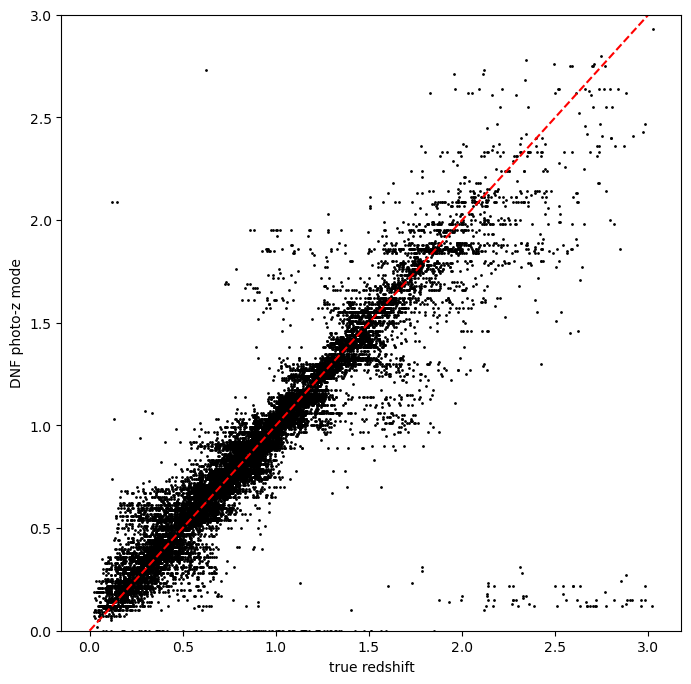

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'],zmode,s=1,c='k',label='DNF mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("DNF photo-z mode")
plt.ylim(0,3)


(0.0, 3.0)

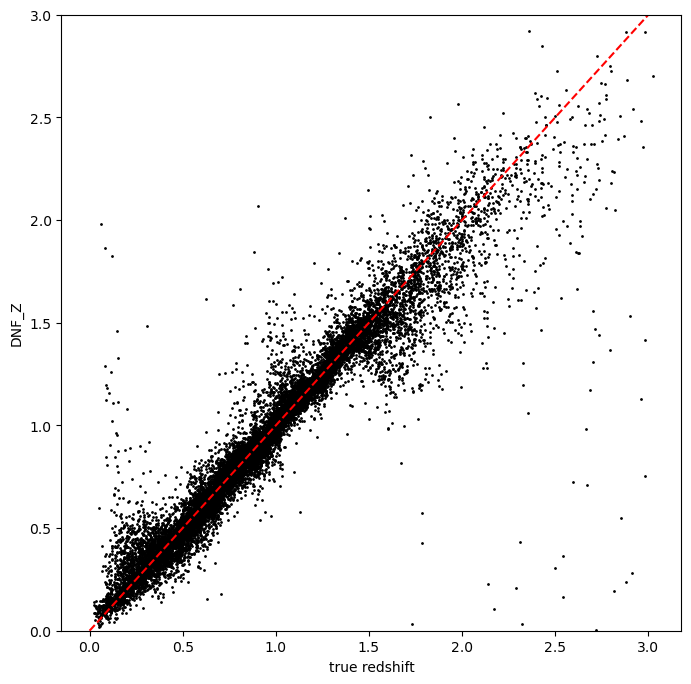

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'], zdnf, s=1, c='k')
plt.plot([0,3],[0,3], 'r--');
plt.xlabel("true redshift")
plt.ylabel("DNF_Z")
plt.ylim(0,3)